## Importing basic libraries for plots and matrix calculations

In [1]:
import numpy as np
import pandas as pd
import random
import os
import math
import pickle
import matplotlib.pyplot as plt

## Reading both feature and label text files and saving into dataframe and viewing first five records

In [2]:
data_img = pd.read_csv('MNISTnumImages5000.txt',sep="\t", header=None)

In [3]:
data_lbl = pd.read_csv('MNISTnumLabels5000.txt', sep="\t", header=None)

In [4]:
data_img.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0.0,...,0.0,0.0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0.0,...,0.0,0.0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0.0,...,0.0,0.0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0.0,...,0.0,0.0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0.0,...,0.0,0.0,0,0,0,0,0,0,0,0


In [5]:
data_lbl.head()

,0
0,7
1,2
2,1
3,0
4,4


## Distribution of records digit wise

In [6]:
data_lbl.iloc[:,0].value_counts()

1    571
2    530
9    520
7    512
3    500
4    500
8    489
6    462
0    460
5    456
Name: 0, dtype: int64

## Function to change target to 1,0 representation

In [7]:
def bin_encode(target):
    arr_target = np.zeros((10, 1))
    a=[]
    for i in range(10):
        if i==target:
            a.append([1.])
        else:
            a.append([0.])
    arr_target=np.array(a)
    return arr_target

## Activations functions and their derivative functions

In [8]:
def act_sig(u):
    v = 1.0 / (1.0 + np.exp(-u))
    return v

def act_sig_deri(u):
    v= act_sig(u) * (1 - act_sig(u))
    return v

def act_relu(u):
    v=np.maximum(u,0)
    return v

def act_relu_deri(u):
    u[u<=0]=0
    u[u>0]=1
    return u

def act_tanh(u,a,b):
    v = a * np.tanh(b * u)
    return v

def act_tanh_deri(u,a,b):
    v= (b/a) * ((a*a) - (u * u)) 
    return v

def get_act(act_fun,u):
    if act_fun=="sigmoid":
        return act_sig(u)
    elif act_fun=="relu":
        return act_relu(u)
    elif act_fun=="tanh":
        a=1.7159
        b=2/3
        return act_tanh(u,a,b)
    else:
        raise ValueError('Activation function not found')
        
def get_act_derv(act_fun,u):
    if act_fun=="sigmoid":
        return act_sig_deri(u)
    elif act_fun=="relu":
        return act_relu_deri(u)
    elif act_fun=="tanh":
        a=1.7159
        b=2/3
        return act_tanh_deri(u,a,b)
    else:
        raise ValueError('Activation function not found')
    

## Multi layer Feed forward network (with changes to include regularizations to get sparse autoencoder) implementation with following parameters as inputs :
layers_list :- list containing input neurons , hidden layers neurons , output layer neurons in same order.
activations :- list containing corresponding activation functions (sigmoid, relu ,tanh) first element of list can be anything as                inputs will be first activations and so no need of activation function.
lr          :- learning rate
momentum    :- momentum
iters       :- epochs
bat_size    :- batch size for Stochaistic Gradient Descent
auto        :- flag to run second ques as it involves calculating cost function which is not needed for ques 1 as in HW3
prow        :- Sparseness target (ρ)
beta        :- Lagrange multiplier- Beta (β)
sparse      :- flag to include sparse regularization or not 

In [34]:
class Model(object):

    def __init__(self, layer_list=list(),act_list=list(), lr=1.0,momentum=0.1,iters=10, bat_size=16, auto=False,prow=0.05,beta=3,sparse=True):
        
        self.eta = lr
        self.beta = beta
        self.prow = prow
        self.sparse = sparse
        self.momentum = momentum
        self.iters = iters
        self.bat_size = bat_size
        self.auto=auto
        self.layer_list = layer_list
        self.layers_len = len(layer_list)
        self.act_list=act_list
        self.act_len = len(act_list)
        if self.layers_len != self.act_len:
            raise ValueError('Activations and Layers size should match')
            
        self.W=[]
        self.W.append(np.array([0]))
        for i in range(1,len(layer_list)):
            a=math.sqrt(6/layer_list[i-1])
            tmp=np.zeros((layer_list[i],layer_list[i-1]))
            for j in range(layer_list[i]):
                tmp[j]=np.random.uniform(-a, a, layer_list[i-1])
            self.W.append(tmp)
        
        self.B = [np.zeros((i,1)) for i in layer_list]
        self.S = [np.zeros((i,1)) for i in layer_list]
        self.A = [np.zeros((i,1)) for i in layer_list]
        
        if self.auto:
            self.store("auto-intial-"+str(self.layer_list[1])+".pkl")
        else:
            self.store("model-intial-"+str(self.layer_list[1])+".pkl")
        
       

    def train(self, dt_train, dt_val, dt_test, auto,sparse):
        
        flag=0
        thr=[]
        vhr=[]
        tehr=[]
        
        tc=[]
        vc=[]
        tec=[]
        
        if auto:
            train_cost = (self.getError(dt_train))
            val_cost = (self.getError(dt_val))
            test_cost =(self.getError(dt_test))
            tc.append(train_cost)
            vc.append(val_cost)
            tec.append(test_cost)
            print("For epoch {0}, validating error {1} , training error {2} , testing error {3}.".format(0,val_cost,train_cost,test_cost))
        else:
            train_hit_rate = (self.validateTrain(dt_train)) / (len(dt_train))
            val_hit_rate = (self.validate(dt_val)) / (len(dt_val))
            test_hit_rate =(self.validate(dt_test)) / (len(dt_test))
            thr.append(train_hit_rate)
            vhr.append(val_hit_rate)
            tehr.append(test_hit_rate)
            print("For epoch {0}, validating hit rate {1} , training hit rate {2} , testing hit rate {3}.".format(0,val_hit_rate,train_hit_rate,test_hit_rate))
         
        
        for itr in range(self.iters):
            random.shuffle(dt_train)
            train_subsets=[]
            for i in range(0, len(dt_train), self.bat_size):
                train_subsets.append(dt_train[i:i + self.bat_size])
                
            main_delta_b= [np.zeros(b.shape) for b in self.B]
            main_delta_w= [np.zeros(w.shape) for w in self.W]
            
            for dt_train_batch in train_subsets:
                delta_b = [np.zeros(b.shape) for b in self.B]
                delta_w = [np.zeros(w.shape) for w in self.W]
                #### Start : Changes to get rho_j_cap for including sparse regularization to code in hw3 ####
                if sparse:
                    temp_S=[np.zeros((i,1)) for i in self.layer_list]
                    temp_A=[np.zeros((i,1)) for i in self.layer_list]
                    lis=[]
                    for features, targets in dt_train_batch:
                        temp_A[0] = features
                        temp_S[1] = (self.W[1].dot(temp_A[0]) + self.B[1])
                        temp_A[1] = get_act(self.act_list[1],temp_S[1])
                        temp_B=np.copy(temp_A)
                        lis.append(temp_B)
                    prow_cap=[sum(x)/len(dt_train_batch) for x in zip(*lis)]
                    #print(prow_cap[1])
                
                #### End : Changes to get rho_j_cap for including sparse regularization to code in hw3 ####
                
                
                for features, targets in dt_train_batch:
                    self.FP(features)
                    if sparse:
                        tmp_delta_b, tmp_delta_w = self.BP(targets,prow_cap,sparse)
                    else:
                        prow_cap=[np.zeros((i,1)) for i in self.layer_list]
                        tmp_delta_b, tmp_delta_w = self.BP(targets,prow_cap,sparse)
                        
                    delta_b = [db + tdb  for db, tdb in zip(delta_b, tmp_delta_b)]
                    delta_w = [dw + tdw  for dw, tdw in zip(delta_w, tmp_delta_w)]
                
                prev_delta_b = main_delta_b
                prev_delta_w = main_delta_w
                #######ADDED WEIGHT DECAY TERM TO UPDATE DELTA WEIGHT#########################
                main_delta_w = [((self.eta / self.bat_size )* del_w) + (self.momentum * p_d_w) -(self.bat_size * 0.0001 * we) for del_w,p_d_w,we in zip (delta_w,prev_delta_w,self.W)] 
                #main_delta_w = [((self.eta / self.bat_size )* del_w) + (self.momentum * p_d_w) for del_w,p_d_w in zip (delta_w,prev_delta_w)] 
                main_delta_b = [((self.eta / self.bat_size )* del_b) + (self.momentum * p_d_b)  for del_b,p_d_b in zip (delta_b,prev_delta_b)]
                
                self.updateWeights(main_delta_w, main_delta_b)
                
            if not (itr+1) % 10:
                if auto:
                    train_cost = (self.getError(dt_train))
                    val_cost = (self.getError(dt_val))
                    test_cost =(self.getError(dt_test))
                    tc.append(train_cost)
                    vc.append(val_cost)
                    tec.append(test_cost)
                    print("For epoch {0}, validating error {1} , training error {2} , testing error {3}.".format(itr + 1,val_cost,train_cost,test_cost))
                    if len(vc)>3:
                        if ((vc[-1]>vc[-2] and vc[-1] > vc[-3] and vc[-1] > vc[-4]) or (vc[-1] ==vc[-2] and vc[-1] ==vc[-2] and vc[-1] ==vc[-3])):
                            flag=1
                else:
                    train_hit_rate = (self.validateTrain(dt_train)) / (len(dt_train))
                    val_hit_rate = (self.validate(dt_val)) / (len(dt_val))
                    test_hit_rate =(self.validate(dt_test)) / (len(dt_test))
                    thr.append(train_hit_rate)
                    vhr.append(val_hit_rate)
                    tehr.append(test_hit_rate)
                    print("For epoch {0}, validating hit rate {1} , training hit rate {2} , testing hit rate {3}.".format(itr + 1,val_hit_rate,train_hit_rate,test_hit_rate))
                    if len(vhr)>3:
                        if ((vhr[-1]<vhr[-2] and vhr[-1] < vhr[-3] and vhr[-1] < vhr[-4]) or (vhr[-1] ==vhr[-2] and vhr[-1] ==vhr[-2] and vhr[-1] ==vhr[-3])):
                            flag=1
                            
            #comment below flag =0 in code to run with stopping rule
            flag=0
            if flag==1:
                if auto:
                    self.store("auto-"+str(self.eta)+"-"+str(self.momentum)+str(self.act_list[-2])+'-'+str(self.act_list[-1])+str(itr+1)+".pkl")
                else:
                    self.store("model-"+str(self.eta)+"-"+str(self.momentum)+str(self.act_list[-2])+'-'+str(self.act_list[-1])+str(itr+1)+".pkl")
                break
                
            if not (itr+1) % 30:
                if auto:
                    self.store("auto-"+str(self.eta)+"-"+str(self.momentum)+str(self.act_list[-2])+'-'+str(self.act_list[-1])+str(itr+1)+".pkl")
                else:
                    self.store("model-"+str(self.eta)+"-"+str(self.momentum)+str(self.act_list[-2])+'-'+str(self.act_list[-1])+str(itr+1)+".pkl")
                    
        return {'thr':thr,'vhr':vhr,'tehr':tehr,'vc':vc,'tc':tc,'tec':tec}
                
    def getError(self,dt):
        mainCost=0
        for feat, targ in dt:
            pred=self.test_auto(feat)
            err=targ-pred
            sqEr=err  * err
            tmpCost=(1/2) * np.sum(sqEr)
            mainCost=mainCost+tmpCost
        return mainCost
    
    def Average_act_FP(self, features,A,S):
        A[0] = features
        for i in range(1, self.layers_len):
            S[i] = (self.W[i].dot(A[i - 1]) + self.B[i])
            A[i] = get_act(self.act_list[i],S[i])
        B=np.copy(A)
        return B
    
    def updateWeights(self, main_delta_w, main_delta_b):
        
        self.W = [w + delw for w, delw  in zip(self.W, main_delta_w)]
        self.B = [b + delb for b, delb in zip(self.B, main_delta_b)]
    
    def validate(self, dt_val):
        corr_points=0
        for feat, targ in dt_val:
            if self.test(feat) == targ:
                corr_points=corr_points+1
        return corr_points
    
    def validateTrain(self, dt_val):
        ft = []
        lb=  []
        for i, j in dt_val:
            ft.append(i)
            lb.append(np.argmax(j))
        dt=list(zip(ft,lb))
        corr_points=0
        for feat, targ in dt:
            if self.test(feat) == targ:
                corr_points=corr_points+1
        return corr_points

    def test(self, features):
        self.FP(features)
        return np.argmax(self.A[-1])
    
    def test_auto(self, features):
        self.FP(features)
        return self.A[-1]

    def FP(self, features):
        self.A[0] = features
        for i in range(1, self.layers_len):
            self.S[i] = (self.W[i].dot(self.A[i - 1]) + self.B[i])
            self.A[i] = get_act(self.act_list[i],self.S[i])
            
    def BP(self, target, prow_cap,sparse):
        delta_b = [np.zeros(b.shape) for b in self.B]
        delta_w = [np.zeros(w.shape) for w in self.W]
        #delta for output layer
        tmp_del = (target-self.A[-1]) * get_act_derv(self.act_list[-1],self.S[-1])
        delta_b[-1] = tmp_del
        delta_w[-1] = tmp_del.dot(self.A[-2].transpose())
        #delta for hidden layes
        for l in range(self.layers_len - 2, 0, -1):
            
            ########ADDING CHANGES AFTER CONSIDER REGULARIZATION PENALITY STEP#############
            if sparse and l!=0:
                KL_penality=self.beta * (((1-self.prow)/(1-prow_cap[l]))-(self.prow/prow_cap[l]))
                new_penality=self.W[l + 1].transpose().dot(tmp_del) - KL_penality
                tmp_del = np.multiply(new_penality,get_act_derv(self.act_list[l],self.S[l]))
            else:
                tmp_del = np.multiply(self.W[l + 1].transpose().dot(tmp_del),get_act_derv(self.act_list[l],self.S[l]))
                
            delta_b[l] = tmp_del
            delta_w[l] = tmp_del.dot(self.A[l - 1].transpose())
        return delta_b, delta_w

    def store(self, file='weights.pkl'):
        
        lr=self.eta
        
        bet=self.beta
        pr=self.prow
        spar=self.sparse
        
        mm=self.momentum 
        iters=self.iters 
        bs=self.bat_size
        
        ll=self.layer_list 
        al=self.act_list
        
        W=self.W
        B=self.B
        
        dict={'bet':bet,'pr':pr,'spar':spar,'lr':lr,'mm':mm,'iters':iters,'bs':bs,'ll':ll,'al':al,'W':W,'B':B}
        with open(os.path.join(os.curdir, file), 'wb') as f: 
            pickle.dump(dict, f)
        
    def load(self, epoch, lr,mm,pr,bet,spar, file='weights.pkl', actFun_list=['NR','sigmoid','sigmoid']):
       
        with open(os.path.join(os.curdir, file),'rb') as f:  
            objb= pickle.load(f)
        self.eta=lr 
        self.beta=bet
        self.prow=pr 
        self.sparse=spar 
        self.momentum=mm
        self.iters = epoch
        self.bat_size=int(objb['bs'])
        self.act_list=actFun_list
        self.act_len = len(self.act_list)
        self.W = list(objb['W'])
        self.B = list(objb['B'])
        self.layer_list = [b.shape[0] for b in self.B]
        self.layers_len = len(self.layer_list)
        self.S = [np.zeros(b.shape) for b in self.B]
        self.A = [np.zeros(b.shape) for b in self.B]

## Splitting Data into train and test and viewing corresponding digit distribution

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data_img, data_lbl, test_size=0.2, random_state=0 , stratify=data_lbl)

In [12]:
Y_train.iloc[:,0].value_counts()

1    457
2    424
9    416
7    409
3    400
4    400
8    391
6    370
0    368
5    365
Name: 0, dtype: int64

In [13]:
Y_test.iloc[:,0].value_counts()

1    114
2    106
9    104
7    103
4    100
3    100
8     98
6     92
0     92
5     91
Name: 0, dtype: int64

## splitting train into train_new and validation dataset with 3500 points as train_new and 500 as validation set

In [14]:
X_train_new, X_valid, Y_train_new, Y_valid = train_test_split(X_train, Y_train, test_size=0.125, random_state=0 , stratify=Y_train)

In [15]:
Y_train_new.iloc[:,0].value_counts()

1    400
2    371
9    364
7    358
3    350
4    350
8    342
6    324
0    322
5    319
Name: 0, dtype: int64

In [16]:
Y_valid.iloc[:,0].value_counts()

1    57
2    53
9    52
7    51
4    50
3    50
8    49
6    46
5    46
0    46
Name: 0, dtype: int64

## Changing input and output into 2d array

In [17]:
arr_x_train = [np.reshape(X_train_new.iloc[i,:].tolist(), (len(X_train_new.columns), 1)) for i in range(len(X_train_new))]
arr_y_train = [bin_encode(y) for y in Y_train_new.iloc[:,0].tolist()]
data_train = list(zip(arr_x_train, arr_y_train))

In [18]:
arr_x_val = [np.reshape(X_valid.iloc[i,:].tolist(), (len(X_valid.columns), 1)) for i in range(len(X_valid))]
arr_y_val = Y_valid.iloc[:,0].tolist()
data_val = list(zip(arr_x_val, arr_y_val))

In [19]:
arr_x_test = [np.reshape(X_test.iloc[i,:].tolist(), (len(X_test.columns), 1)) for i in range(len(X_test))]
arr_y_test = Y_test.iloc[:,0].tolist()
data_test = list(zip(arr_x_test, arr_y_test))

## Preparing data for auto encoder where target variables will be same as input

In [20]:
arr_x_train_auto = [np.reshape(X_train_new.iloc[i,:].tolist(), (len(X_train_new.columns), 1)) for i in range(len(X_train_new))]
data_train_auto = list(zip(arr_x_train_auto, arr_x_train_auto))

In [21]:
arr_x_val_auto = [np.reshape(X_valid.iloc[i,:].tolist(), (len(X_valid.columns), 1)) for i in range(len(X_valid))]
data_val_auto = list(zip(arr_x_val_auto, arr_x_val_auto))

In [22]:
arr_x_test_auto = [np.reshape(X_test.iloc[i,:].tolist(), (len(X_test.columns), 1)) for i in range(len(X_test))]
data_test_auto = list(zip(arr_x_test_auto, arr_x_test_auto))

## start experimenting with sparse

In [35]:
# After balanced split

#initialize layer sizes as list
layers = [784,150,784]
act_funcs=['NR','sigmoid','sigmoid']
momentum = 0.7
lr = 0.1
itrs = 1
batch_size = 32
# def __init__(self, layer_list=list(),act_list=list(), lr=1.0,momentum=0.1,iters=10, bat_size=16, auto=False,prow=0.05,beta=3,sparse=True):

nn = Model(layers,act_funcs, lr, momentum, itrs, batch_size,True,0.05,4,True)

#training neural network
Run_sample=nn.train(data_train_auto, data_val_auto, data_test_auto,True,True)

For epoch 0, validating error 49100.88495461169 , training error 343389.02357950783 , testing error 98117.10571594058.
For epoch 1, validating error 14249.626422271978 , training error 100329.67645459216 , testing error 28885.27306941044.


In [36]:
nn.load(5,10,0.7,0.05,4,True,'auto-intial-150.pkl',['NR','sigmoid','sigmoid'])
Run_FINAL_FIXED_lr1=nn.train(data_train_auto, data_val_auto, data_test_auto,True,True)

For epoch 0, validating error 49933.20485488814 , training error 349459.36153174436 , testing error 99810.50558674452.


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:235: RuntimeWarning: divide by zero encountered in true_divide
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in multiply


For epoch 1, validating error nan , training error nan , testing error nan.
For epoch 2, validating error nan , training error nan , testing error nan.
For epoch 3, validating error nan , training error nan , testing error nan.
For epoch 4, validating error nan , training error nan , testing error nan.
For epoch 5, validating error nan , training error nan , testing error nan.


In [37]:
nn.load(5,3,0.7,0.05,4,True,'auto-intial-150.pkl',['NR','sigmoid','sigmoid'])
Run_FINAL_FIXED_lr1=nn.train(data_train_auto, data_val_auto, data_test_auto,True,True)

For epoch 0, validating error 49933.20485488814 , training error 349459.3615317432 , testing error 99810.50558674452.


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


For epoch 1, validating error 12030.937087487517 , training error 84818.57782684655 , testing error 24463.93895674152.
For epoch 2, validating error 9927.150152356575 , training error 70734.25324716755 , testing error 20537.634116604993.
For epoch 3, validating error 8615.236904232006 , training error 60662.144238493966 , testing error 17657.34412175628.
For epoch 4, validating error 7895.325216481987 , training error 55579.438462183345 , testing error 16387.911671254238.
For epoch 5, validating error 7874.143996558741 , training error 54727.16425964364 , testing error 16097.468128307322.


In [38]:
nn.load(5,1,0.7,0.05,4,True,'auto-intial-150.pkl',['NR','sigmoid','sigmoid'])
Run_FINAL_FIXED_lr1=nn.train(data_train_auto, data_val_auto, data_test_auto,True,True)

For epoch 0, validating error 49933.20485488814 , training error 349459.36153174436 , testing error 99810.50558674452.
For epoch 1, validating error 11888.011685481515 , training error 84222.88502230367 , testing error 24286.83632823228.
For epoch 2, validating error 10394.406123742192 , training error 73609.45333223775 , testing error 21375.05621112545.
For epoch 3, validating error 9691.730860149835 , training error 68353.56711063377 , testing error 19875.8262898388.
For epoch 4, validating error 8575.912091522598 , training error 60569.52822208849 , testing error 17609.493065499235.
For epoch 5, validating error 8193.25580877851 , training error 57371.08663228945 , testing error 16786.670160949823.


In [39]:
nn.load(5,2,0.7,0.05,4,True,'auto-intial-150.pkl',['NR','sigmoid','sigmoid'])
Run_FINAL_FIXED_lr1=nn.train(data_train_auto, data_val_auto, data_test_auto,True,True)

For epoch 0, validating error 49933.20485488814 , training error 349459.3615317444 , testing error 99810.50558674452.
For epoch 1, validating error 11655.823786834464 , training error 82555.13579780287 , testing error 23943.943335948363.
For epoch 2, validating error 10164.214830749648 , training error 71727.27930504667 , testing error 20934.017254081235.
For epoch 3, validating error 8227.02286483407 , training error 57928.050753693155 , testing error 16814.510940484757.
For epoch 4, validating error 8297.7614412349 , training error 58052.922286728746 , testing error 17012.071110941808.
For epoch 5, validating error 7642.489934515522 , training error 54108.62119522997 , testing error 15908.076773935372.


In [76]:
nn.load(5,2,0.9,0.05,4,True,'auto-intial-150.pkl',['NR','sigmoid','sigmoid'])
Run_FINAL_FIXED_mm=nn.train(data_train_auto, data_val_auto, data_test_auto,True,True)

For epoch 0, validating error 49933.20485488814 , training error 349459.36153174407 , testing error 99810.50558674452.


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


For epoch 1, validating error 11454.75281808511 , training error 81289.27213436976 , testing error 23545.469657971553.
For epoch 2, validating error 9751.727848431392 , training error 68991.48961774618 , testing error 20110.380298579785.
For epoch 3, validating error 8966.860056278914 , training error 62877.3023552388 , testing error 18423.710327404082.
For epoch 4, validating error 8490.420183526145 , training error 59854.401243457585 , testing error 17593.931972259586.
For epoch 5, validating error 8426.84866927705 , training error 60071.46912175971 , testing error 17549.364369562965.


In [78]:
nn.load(5,0.9,0.9,0.08,4,True,'auto-intial-150.pkl',['NR','sigmoid','sigmoid'])
Run_FINAL_FIXED_mm=nn.train(data_train_auto, data_val_auto, data_test_auto,True,True)

For epoch 0, validating error 49933.20485488814 , training error 349459.36153174465 , testing error 99810.50558674452.
For epoch 1, validating error 9664.504501987443 , training error 68835.03810117152 , testing error 19992.113965986566.
For epoch 2, validating error 8407.469215634834 , training error 59542.76323760866 , testing error 17151.992695385037.
For epoch 3, validating error 8220.564707684971 , training error 58136.955136317774 , testing error 16970.401610800764.


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


For epoch 4, validating error 8105.67251259138 , training error 57633.4354601264 , testing error 16714.011640168123.
For epoch 5, validating error 8502.614683845939 , training error 59436.92808116666 , testing error 17280.2446914.


In [79]:
nn.load(5,0.9,0.9,0.03,4,True,'auto-intial-150.pkl',['NR','sigmoid','sigmoid'])
Run_FINAL_FIXED_mm=nn.train(data_train_auto, data_val_auto, data_test_auto,True,True)

For epoch 0, validating error 49933.20485488814 , training error 349459.3615317436 , testing error 99810.50558674452.


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


For epoch 1, validating error 11467.83862255095 , training error 81236.24762319177 , testing error 23477.866462729406.
For epoch 2, validating error 8694.158426409647 , training error 60715.862166431456 , testing error 17697.970982880324.
For epoch 3, validating error 8876.520590271879 , training error 61853.96858298023 , testing error 18030.981472157313.
For epoch 4, validating error 9095.167552935285 , training error 63988.95722533779 , testing error 18662.716057345067.
For epoch 5, validating error 8260.610337102322 , training error 57831.03324812311 , testing error 16900.842342707238.


In [80]:
nn.load(5,0.9,0.7,0.03,4,True,'auto-intial-150.pkl',['NR','sigmoid','sigmoid'])
Run_FINAL_FIXED_mm=nn.train(data_train_auto, data_val_auto, data_test_auto,True,True)

For epoch 0, validating error 49933.20485488814 , training error 349459.3615317434 , testing error 99810.50558674452.
For epoch 1, validating error 11496.183143195341 , training error 81544.70027862911 , testing error 23526.730804488714.
For epoch 2, validating error 10087.786789539214 , training error 70514.77963652647 , testing error 20436.20674899979.
For epoch 3, validating error 8633.05109558867 , training error 60558.20518215448 , testing error 17584.052209111047.
For epoch 4, validating error 8286.721492006864 , training error 58005.07516178725 , testing error 16936.5570824876.
For epoch 5, validating error 8351.619745787992 , training error 59035.72413406976 , testing error 17298.632474997492.


In [81]:
nn.load(5,0.9,0.7,0.03,2,True,'auto-intial-150.pkl',['NR','sigmoid','sigmoid'])
Run_FINAL_FIXED_mm=nn.train(data_train_auto, data_val_auto, data_test_auto,True,True)

For epoch 0, validating error 49933.20485488814 , training error 349459.36153174477 , testing error 99810.50558674452.
For epoch 1, validating error 11901.546854597987 , training error 84147.80086994442 , testing error 24270.002434186445.
For epoch 2, validating error 10783.681215379922 , training error 76426.34157239615 , testing error 22109.088627818554.
For epoch 3, validating error 9376.00310010207 , training error 66338.74592378199 , testing error 19239.186582010087.
For epoch 4, validating error 8305.3895885737 , training error 58738.4968285941 , testing error 17083.757366637074.
For epoch 5, validating error 7966.648280737119 , training error 56172.731187537676 , testing error 16386.9226180953.


In [82]:
nn.load(5,0.9,0.7,0.03,10,True,'auto-intial-150.pkl',['NR','sigmoid','sigmoid'])
Run_FINAL_FIXED_mm=nn.train(data_train_auto, data_val_auto, data_test_auto,True,True)

For epoch 0, validating error 49933.20485488814 , training error 349459.36153174407 , testing error 99810.50558674452.


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


For epoch 1, validating error 11800.838951994474 , training error 83719.77944715579 , testing error 24180.91042228301.
For epoch 2, validating error 11122.411155340498 , training error 78683.59447010049 , testing error 22814.42539714851.
For epoch 3, validating error 9785.175537472442 , training error 68909.67295963035 , testing error 19907.622303452852.
For epoch 4, validating error 8821.518809925112 , training error 62182.164770035175 , testing error 17932.620813357706.
For epoch 5, validating error 8633.253535642913 , training error 60209.18386178583 , testing error 17454.215703164034.


In [77]:
nn.load(5,0.9,0.9,0.05,4,True,'auto-intial-150.pkl',['NR','sigmoid','sigmoid'])
Run_FINAL_FIXED_mm=nn.train(data_train_auto, data_val_auto, data_test_auto,True,True)

For epoch 0, validating error 49933.20485488814 , training error 349459.36153174343 , testing error 99810.50558674452.
For epoch 1, validating error 11278.696835641591 , training error 79787.3876600649 , testing error 23142.338983388257.
For epoch 2, validating error 8719.747388740738 , training error 61738.64820446597 , testing error 17995.026929917654.
For epoch 3, validating error 8439.608097122777 , training error 59645.77610693468 , testing error 17441.445661423124.
For epoch 4, validating error 8313.990697943127 , training error 58489.842014342954 , testing error 17004.07830681833.
For epoch 5, validating error 8603.51281752803 , training error 60573.59836823827 , testing error 17654.525225945436.


In [40]:
nn.load(500,0.9,0.7,0.05,4,True,'auto-intial-150.pkl',['NR','sigmoid','sigmoid'])
Run_FINAL_FIXED_lr1=nn.train(data_train_auto, data_val_auto, data_test_auto,True,True)

For epoch 0, validating error 49933.20485488814 , training error 349459.3615317443 , testing error 99810.50558674452.
For epoch 1, validating error 11957.170001581862 , training error 84266.53199920843 , testing error 24321.611715414354.
For epoch 2, validating error 10946.55587419628 , training error 77195.88297331122 , testing error 22342.327392536885.
For epoch 3, validating error 8860.11813144706 , training error 62547.0602894927 , testing error 18242.01485395699.
For epoch 4, validating error 8422.649937774007 , training error 59500.22808178029 , testing error 17284.323090456408.
For epoch 5, validating error 8073.32835875245 , training error 56014.23521057325 , testing error 16315.114781720753.
For epoch 6, validating error 7863.961748164031 , training error 55120.42954033959 , testing error 16069.878618067278.
For epoch 7, validating error 7548.854245712256 , training error 53206.87954591325 , testing error 15500.821488523767.
For epoch 8, validating error 7632.873324270812 , tr

For epoch 69, validating error 7197.125542690523 , training error 50688.66881162337 , testing error 14757.526174966753.
For epoch 70, validating error 7510.7081729852025 , training error 52295.09734913547 , testing error 15339.666551533863.
For epoch 71, validating error 7163.467751493481 , training error 50023.34505754634 , testing error 14642.824890608123.
For epoch 72, validating error 7171.026568354727 , training error 49992.966924623935 , testing error 14678.851298257083.
For epoch 73, validating error 7359.035893766206 , training error 51298.72026153069 , testing error 14987.577183583699.
For epoch 74, validating error 7371.788118556437 , training error 51818.75963275428 , testing error 15070.474256344618.
For epoch 75, validating error 7353.447378464207 , training error 51549.390292768534 , testing error 15114.094480221056.
For epoch 76, validating error 7184.143110922847 , training error 50332.7980635056 , testing error 14749.90017532128.
For epoch 77, validating error 7426.544

For epoch 137, validating error 7422.636400516363 , training error 52269.67023848066 , testing error 15331.544460358207.
For epoch 138, validating error 7090.706260730448 , training error 49998.01360021264 , testing error 14595.95809933003.
For epoch 139, validating error 7249.953716286105 , training error 50637.2435272652 , testing error 14816.51386256304.
For epoch 140, validating error 7225.741088425199 , training error 50352.300090787394 , testing error 14719.610925757388.
For epoch 141, validating error 7131.475125411625 , training error 50052.80827095525 , testing error 14657.037495925491.
For epoch 142, validating error 7463.202734171593 , training error 52141.078538586386 , testing error 15244.093225131595.
For epoch 143, validating error 7454.711166983197 , training error 52356.0113953484 , testing error 15259.773000157058.
For epoch 144, validating error 7547.565948726002 , training error 52961.69589194814 , testing error 15403.5507650429.
For epoch 145, validating error 7339

For epoch 205, validating error 7114.633462886006 , training error 49578.190748596004 , testing error 14503.908566721177.
For epoch 206, validating error 7317.383691985783 , training error 51274.15415658936 , testing error 15064.490348010204.
For epoch 207, validating error 7713.591356625866 , training error 53295.02505899696 , testing error 15531.742712025722.
For epoch 208, validating error 7358.950676288015 , training error 51074.527356753344 , testing error 14920.514317186355.
For epoch 209, validating error 7371.9945148917795 , training error 51282.89094945159 , testing error 15021.279978330303.
For epoch 210, validating error 7366.77364991299 , training error 51510.63110214061 , testing error 15062.0428700118.
For epoch 211, validating error 7621.288361498753 , training error 53129.33018149648 , testing error 15556.645408105396.
For epoch 212, validating error 7112.376111441692 , training error 49999.57533219114 , testing error 14553.578345781181.
For epoch 213, validating error 

For epoch 273, validating error 7291.375967353241 , training error 51345.08081571049 , testing error 14943.27682338163.
For epoch 274, validating error 7544.402258512861 , training error 53250.69033446056 , testing error 15490.117386823917.
For epoch 275, validating error 7315.605930927517 , training error 50976.70024311573 , testing error 14949.572857296964.
For epoch 276, validating error 7352.8198796130955 , training error 51374.916931351574 , testing error 14972.159455642895.
For epoch 277, validating error 7215.4405628842005 , training error 50277.81370064864 , testing error 14750.776129664857.
For epoch 278, validating error 7230.72445650828 , training error 50937.18564640436 , testing error 14857.758843744443.
For epoch 279, validating error 7125.786480628892 , training error 50463.7064561632 , testing error 14641.341889260862.
For epoch 280, validating error 7503.753056953031 , training error 52749.58618031537 , testing error 15399.119801099096.
For epoch 281, validating error 

For epoch 341, validating error 7371.743578582177 , training error 51471.31072109966 , testing error 15149.225120953057.
For epoch 342, validating error 6954.249661835007 , training error 49077.81973055561 , testing error 14347.575679655354.
For epoch 343, validating error 6965.332099423312 , training error 48940.453502197095 , testing error 14261.590123496386.
For epoch 344, validating error 7111.623775089362 , training error 49761.08884192081 , testing error 14534.987041382668.
For epoch 345, validating error 7048.066862682982 , training error 49297.982625519166 , testing error 14502.55962970274.
For epoch 346, validating error 7261.1084143576745 , training error 50489.41892672817 , testing error 14845.445413605446.
For epoch 347, validating error 7516.654978008039 , training error 52479.41125777639 , testing error 15283.777185664996.
For epoch 348, validating error 7433.193528083123 , training error 51838.55404407375 , testing error 15069.69638926773.
For epoch 349, validating error

For epoch 409, validating error 7086.123578341293 , training error 49650.82598648738 , testing error 14527.191806903804.
For epoch 410, validating error 7161.813025336187 , training error 49958.717844632956 , testing error 14647.732519682397.
For epoch 411, validating error 7340.225115981544 , training error 51230.6381478142 , testing error 15002.08275111361.
For epoch 412, validating error 6959.438337089917 , training error 48757.81319814514 , testing error 14288.326291041541.
For epoch 413, validating error 7041.1327419626705 , training error 49228.54499721753 , testing error 14382.919301359445.
For epoch 414, validating error 7002.422592033091 , training error 48907.58708732763 , testing error 14303.975557314345.
For epoch 415, validating error 6981.456912841492 , training error 49036.0435717376 , testing error 14456.292116651057.
For epoch 416, validating error 7063.320958614269 , training error 49060.55046076492 , testing error 14435.046554392993.
For epoch 417, validating error 6

For epoch 477, validating error 7265.230130471763 , training error 50882.61569513328 , testing error 14829.013157369936.
For epoch 478, validating error 7029.24464374754 , training error 49360.64880165026 , testing error 14526.222546645791.
For epoch 479, validating error 7435.9905234866255 , training error 51762.47188098593 , testing error 15256.738522674015.
For epoch 480, validating error 7088.324412120567 , training error 49771.02163439433 , testing error 14451.743797192963.
For epoch 481, validating error 7074.887732849043 , training error 49394.2283878657 , testing error 14472.583738585856.
For epoch 482, validating error 6966.886528119086 , training error 49106.339313061 , testing error 14313.101042983446.
For epoch 483, validating error 6966.360388897455 , training error 48924.48470416364 , testing error 14255.800585130184.
For epoch 484, validating error 6985.001521697844 , training error 48735.70208793862 , testing error 14348.750281780653.
For epoch 485, validating error 704

## end experimenting with sparse

## Final ran for fine tuned parameters for pb1-hw4

In [101]:
nn.load(500,0.9,0.9,0.03,4,True,'auto-intial-150.pkl',['NR','sigmoid','sigmoid'])
Run_FINAL_FIXED_lr2=nn.train(data_train_auto, data_val_auto, data_test_auto,True,True)

For epoch 0, validating error 49933.20485488814 , training error 349459.36153174366 , testing error 99810.50558674452.


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


For epoch 1, validating error 11523.089385005735 , training error 81610.35889795408 , testing error 23651.77844821837.
For epoch 2, validating error 9448.236279916227 , training error 66629.37085951088 , testing error 19449.94078558871.
For epoch 3, validating error 8621.41150614704 , training error 59898.52351614076 , testing error 17533.88878032845.
For epoch 4, validating error 8536.315280268404 , training error 60018.66753153401 , testing error 17411.98896885554.
For epoch 5, validating error 8406.388965868588 , training error 58631.380533348005 , testing error 17086.268320858788.
For epoch 6, validating error 8751.943722527441 , training error 61753.18846807899 , testing error 18034.60738209718.
For epoch 7, validating error 8350.461170107787 , training error 58901.63619714811 , testing error 17078.602084978524.
For epoch 8, validating error 8358.575058429578 , training error 59245.67462131614 , testing error 17324.120977224527.
For epoch 9, validating error 8799.14916605337 , tra

For epoch 70, validating error 8095.032077602659 , training error 57651.64118492389 , testing error 16677.20065677353.
For epoch 71, validating error 8034.321909155694 , training error 56893.57125962689 , testing error 16495.223282432886.
For epoch 72, validating error 7954.828989201107 , training error 56757.91197897443 , testing error 16405.385178637414.
For epoch 73, validating error 8104.682671375385 , training error 57321.19057758577 , testing error 16691.96526009448.
For epoch 74, validating error 8171.409570146952 , training error 57336.46837894906 , testing error 16836.17816262445.
For epoch 75, validating error 8075.152443203134 , training error 56509.91445816387 , testing error 16430.29189166808.
For epoch 76, validating error 8021.788766409777 , training error 56723.20561764605 , testing error 16488.825420725738.
For epoch 77, validating error 8176.50376734236 , training error 57477.137154452736 , testing error 16699.43493658655.
For epoch 78, validating error 8502.556155443

For epoch 139, validating error 8404.332646054676 , training error 59200.62048673072 , testing error 17174.40680128355.
For epoch 140, validating error 8345.102459578111 , training error 58956.84978936865 , testing error 17196.590541788.
For epoch 141, validating error 8117.261568402215 , training error 57678.53499583208 , testing error 16787.348008396388.
For epoch 142, validating error 7937.050218823406 , training error 55239.771687437344 , testing error 16096.740373785158.
For epoch 143, validating error 8186.952608366532 , training error 58089.11902143182 , testing error 16909.065896955166.
For epoch 144, validating error 8016.102146509567 , training error 56550.62110859709 , testing error 16473.311768477568.
For epoch 145, validating error 8022.209775577921 , training error 56524.09900830942 , testing error 16473.318300184066.
For epoch 146, validating error 7866.387399007187 , training error 55367.80442600083 , testing error 16141.005537363926.
For epoch 147, validating error 834

For epoch 207, validating error 8006.606547569906 , training error 55994.932752527995 , testing error 16502.82558251823.
For epoch 208, validating error 8315.199636056037 , training error 58384.17608906128 , testing error 17040.437905606497.
For epoch 209, validating error 8196.02344533792 , training error 57358.82040588099 , testing error 16777.29744146537.
For epoch 210, validating error 8308.498555741504 , training error 58505.94996393252 , testing error 17013.362712769667.
For epoch 211, validating error 7895.885393911805 , training error 55955.15148818169 , testing error 16215.494837156024.
For epoch 212, validating error 8544.771752010738 , training error 59756.9384322518 , testing error 17421.3155889376.
For epoch 213, validating error 8264.896416520885 , training error 57556.926499892914 , testing error 16891.570062087867.
For epoch 214, validating error 8275.195634728892 , training error 57874.59112167811 , testing error 16815.30705122527.
For epoch 215, validating error 8175.

For epoch 275, validating error 8411.754941402545 , training error 59309.77947863143 , testing error 17292.813773121732.
For epoch 276, validating error 8233.778075265649 , training error 58106.322959670564 , testing error 16927.135696196925.
For epoch 277, validating error 8385.463803956518 , training error 59329.76641472672 , testing error 17236.191682958433.
For epoch 278, validating error 8283.806415008487 , training error 57407.63828344072 , testing error 16625.902628469343.
For epoch 279, validating error 7969.638930727547 , training error 56205.47081789673 , testing error 16395.814319890458.
For epoch 280, validating error 8306.3849956986 , training error 58078.927346468365 , testing error 16920.099944757698.
For epoch 281, validating error 8211.81445568569 , training error 57811.937430797174 , testing error 16856.856638610025.
For epoch 282, validating error 7968.538268139002 , training error 56338.57036511257 , testing error 16401.43495397325.
For epoch 283, validating error 8

For epoch 343, validating error 8217.637217870793 , training error 57464.43794446455 , testing error 16755.39870236154.
For epoch 344, validating error 8189.853028358338 , training error 57437.36602108256 , testing error 16816.354066457632.
For epoch 345, validating error 8231.432203182952 , training error 57973.917701393555 , testing error 16883.583372950983.
For epoch 346, validating error 8288.571439510712 , training error 58760.31694575329 , testing error 17088.904909519635.
For epoch 347, validating error 7865.989852715856 , training error 55189.27138614298 , testing error 16168.992401677844.
For epoch 348, validating error 8566.898124387253 , training error 59669.70094578149 , testing error 17541.11965824329.
For epoch 349, validating error 8294.137421278338 , training error 58805.14047153807 , testing error 16944.595963719996.
For epoch 350, validating error 8222.100442479225 , training error 57782.65935665077 , testing error 16864.38901136965.
For epoch 351, validating error 85

For epoch 411, validating error 8296.912696113768 , training error 58684.486975050866 , testing error 17160.083552202006.
For epoch 412, validating error 7962.465495816097 , training error 56518.23846770062 , testing error 16456.116758542677.
For epoch 413, validating error 8391.719313440606 , training error 59000.2067018166 , testing error 17232.897295598297.
For epoch 414, validating error 8511.828122264094 , training error 59971.23992749926 , testing error 17442.24464575294.
For epoch 415, validating error 8317.413308650159 , training error 58476.48760867921 , testing error 17026.706272544187.
For epoch 416, validating error 8327.00064498233 , training error 58616.76313971981 , testing error 17072.747250917688.
For epoch 417, validating error 8141.543484338054 , training error 57080.378473074816 , testing error 16530.40143139079.
For epoch 418, validating error 8282.130788076931 , training error 58611.86193880127 , testing error 17034.293272085473.
For epoch 419, validating error 84

For epoch 479, validating error 8296.680481124688 , training error 59067.680563439935 , testing error 17112.152297254663.
For epoch 480, validating error 8323.524375788718 , training error 58767.07861286856 , testing error 17104.20677772198.
For epoch 481, validating error 8130.81281077724 , training error 57381.11487561838 , testing error 16696.934519903465.
For epoch 482, validating error 8032.208823438285 , training error 56726.92141922925 , testing error 16492.41990224567.
For epoch 483, validating error 7986.770332680912 , training error 56277.22828649942 , testing error 16512.43232913099.
For epoch 484, validating error 8244.733155444957 , training error 57749.61706399228 , testing error 16804.706176368414.
For epoch 485, validating error 8326.416861305104 , training error 58623.7325150783 , testing error 17143.27941896966.
For epoch 486, validating error 8407.180866861101 , training error 59335.37830963725 , testing error 17190.680156997583.
For epoch 487, validating error 8048.

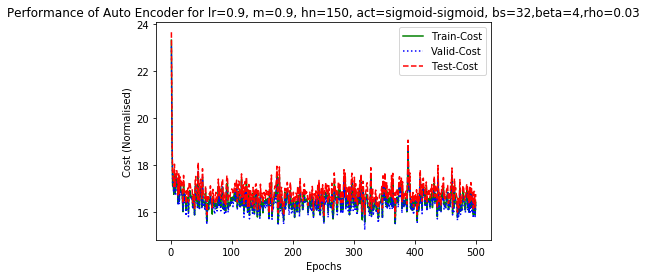

In [118]:
Run_FINAL_FIXED_lr2_tec=[x / 1000 for x in Run_FINAL_FIXED_lr2['tec']]
Run_FINAL_FIXED_lr2_tc=[x / 3500 for x in Run_FINAL_FIXED_lr2['tc']]
Run_FINAL_FIXED_lr2_vc=[x / 500 for x in Run_FINAL_FIXED_lr2['vc']]
tmp1_tec1=[Run_FINAL_FIXED_lr2_tec[x] for x in range(len(Run_FINAL_FIXED_lr2_tec)) ]
tmp1_tc1=[Run_FINAL_FIXED_lr2_tc[x] for x in range(len(Run_FINAL_FIXED_lr2_tc)) ]
tmp1_vc1=[Run_FINAL_FIXED_lr2_vc[x] for x in range(len(Run_FINAL_FIXED_lr2_vc)) ]
epoch = range(1,501)
plt.plot(epoch, tmp1_tc1[1:501], color='g',linestyle='-',label='Train-Cost')
plt.plot(epoch, tmp1_vc1[1:501], color='blue' ,linestyle='dotted',label='Valid-Cost')
plt.plot(epoch, tmp1_tec1[1:501], color='red',linestyle='dashed',label='Test-Cost')
plt.xlabel('Epochs')
plt.ylabel('Cost (Normalised)')
plt.legend()
plt.title('Performance of Auto Encoder for lr=0.9, m=0.9, hn=150, act=sigmoid-sigmoid, bs=32,beta=4,rho=0.03')
plt.show()

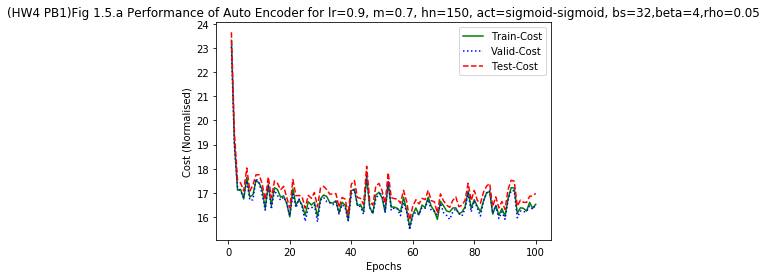

In [139]:
Run_FINAL_FIXED_lr2_tec=[x / 1000 for x in Run_FINAL_FIXED_lr2['tec']]
Run_FINAL_FIXED_lr2_tc=[x / 3500 for x in Run_FINAL_FIXED_lr2['tc']]
Run_FINAL_FIXED_lr2_vc=[x / 500 for x in Run_FINAL_FIXED_lr2['vc']]
tmp1_tec1=[Run_FINAL_FIXED_lr2_tec[x] for x in range(len(Run_FINAL_FIXED_lr2_tec)) ]
tmp1_tc1=[Run_FINAL_FIXED_lr2_tc[x] for x in range(len(Run_FINAL_FIXED_lr2_tc)) ]
tmp1_vc1=[Run_FINAL_FIXED_lr2_vc[x] for x in range(len(Run_FINAL_FIXED_lr2_vc)) ]
epoch = range(1,101)
plt.plot(epoch, tmp1_tc1[1:101], color='g',linestyle='-',label='Train-Cost')
plt.plot(epoch, tmp1_vc1[1:101], color='blue' ,linestyle='dotted',label='Valid-Cost')
plt.plot(epoch, tmp1_tec1[1:101], color='red',linestyle='dashed',label='Test-Cost')
plt.xlabel('Epochs')
plt.ylabel('Cost (Normalised)')
plt.legend()
plt.title('(HW4 PB1)Fig 1.5.a Performance of Auto Encoder for lr=0.9, m=0.7, hn=150, act=sigmoid-sigmoid, bs=32,beta=4,rho=0.05')
plt.show()

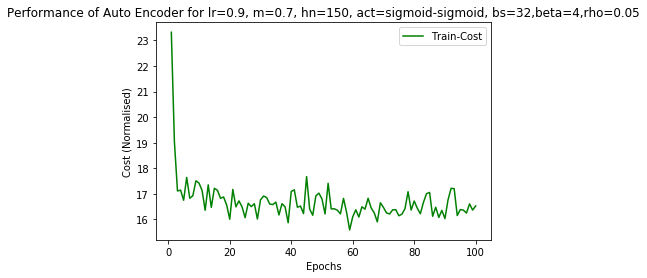

In [127]:
Run_FINAL_FIXED_lr2_tec=[x / 1000 for x in Run_FINAL_FIXED_lr2['tec']]
Run_FINAL_FIXED_lr2_tc=[x / 3500 for x in Run_FINAL_FIXED_lr2['tc']]
Run_FINAL_FIXED_lr2_vc=[x / 500 for x in Run_FINAL_FIXED_lr2['vc']]
tmp1_tec1=[Run_FINAL_FIXED_lr2_tec[x] for x in range(len(Run_FINAL_FIXED_lr2_tec)) ]
tmp1_tc1=[Run_FINAL_FIXED_lr2_tc[x] for x in range(len(Run_FINAL_FIXED_lr2_tc)) ]
tmp1_vc1=[Run_FINAL_FIXED_lr2_vc[x] for x in range(len(Run_FINAL_FIXED_lr2_vc)) ]
epoch = range(1,101)
plt.plot(epoch, tmp1_tc1[1:101], color='g',linestyle='-',label='Train-Cost')
plt.xlabel('Epochs')
plt.ylabel('Cost (Normalised)')
plt.legend()
plt.title('Performance of Auto Encoder for lr=0.9, m=0.7, hn=150, act=sigmoid-sigmoid, bs=32,beta=4,rho=0.05')
plt.show()

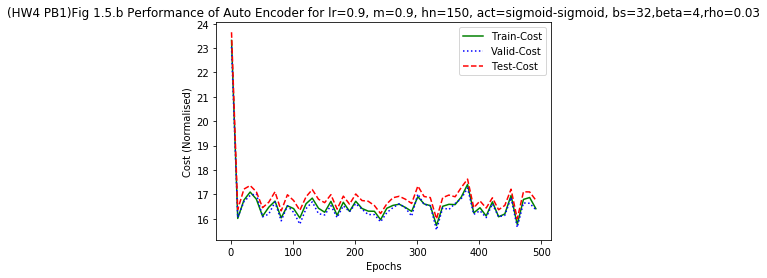

In [140]:
Run_FINAL_FIXED_lr2_tec=[x / 1000 for x in Run_FINAL_FIXED_lr2['tec']]
Run_FINAL_FIXED_lr2_tc=[x / 3500 for x in Run_FINAL_FIXED_lr2['tc']]
Run_FINAL_FIXED_lr2_vc=[x / 500 for x in Run_FINAL_FIXED_lr2['vc']]
tmp1_tec1=[Run_FINAL_FIXED_lr2_tec[x] for x in range(len(Run_FINAL_FIXED_lr2_tec)) if x%10 ==0 ]
tmp1_tc1=[Run_FINAL_FIXED_lr2_tc[x] for x in range(len(Run_FINAL_FIXED_lr2_tc)) if x%10 ==0 ]
tmp1_vc1=[Run_FINAL_FIXED_lr2_vc[x] for x in range(len(Run_FINAL_FIXED_lr2_vc)) if x%10 ==0 ]
#tmp1_tec1.insert(0, Run_FINAL_FIXED_lr1_tec[0])
#tmp1_tc1.insert(0, Run_FINAL_FIXED_lr1_tc[0])
#tmp1_vc1.insert(0, Run_FINAL_FIXED_lr1_vc[0])
tmp1_tec1[1]= Run_FINAL_FIXED_lr2_tec[1]
tmp1_tc1[1]=Run_FINAL_FIXED_lr2_tc[1]
tmp1_vc1[1]=Run_FINAL_FIXED_lr2_vc[1]
epoch = range(1,501,10)
#epoch.insert(0, 1)
plt.plot(epoch, tmp1_tc1[1:], color='g',linestyle='-',label='Train-Cost')
plt.plot(epoch, tmp1_vc1[1:], color='blue' ,linestyle='dotted',label='Valid-Cost')
plt.plot(epoch, tmp1_tec1[1:], color='red',linestyle='dashed',label='Test-Cost')
plt.xlabel('Epochs')
plt.ylabel('Cost (Normalised)')
plt.legend()
plt.title('(HW4 PB1)Fig 1.5.b Performance of Auto Encoder for lr=0.9, m=0.9, hn=150, act=sigmoid-sigmoid, bs=32,beta=4,rho=0.03')
plt.show()

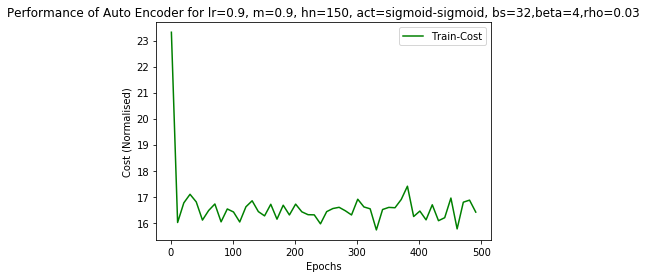

In [126]:
Run_FINAL_FIXED_lr2_tec=[x / 1000 for x in Run_FINAL_FIXED_lr2['tec']]
Run_FINAL_FIXED_lr2_tc=[x / 3500 for x in Run_FINAL_FIXED_lr2['tc']]
Run_FINAL_FIXED_lr2_vc=[x / 500 for x in Run_FINAL_FIXED_lr2['vc']]
tmp1_tec1=[Run_FINAL_FIXED_lr2_tec[x] for x in range(len(Run_FINAL_FIXED_lr2_tec)) if x%10 ==0 ]
tmp1_tc1=[Run_FINAL_FIXED_lr2_tc[x] for x in range(len(Run_FINAL_FIXED_lr2_tc)) if x%10 ==0 ]
tmp1_vc1=[Run_FINAL_FIXED_lr2_vc[x] for x in range(len(Run_FINAL_FIXED_lr2_vc)) if x%10 ==0 ]
#tmp1_tec1.insert(0, Run_FINAL_FIXED_lr1_tec[0])
#tmp1_tc1.insert(0, Run_FINAL_FIXED_lr1_tc[0])
#tmp1_vc1.insert(0, Run_FINAL_FIXED_lr1_vc[0])
tmp1_tec1[1]= Run_FINAL_FIXED_lr2_tec[1]
tmp1_tc1[1]=Run_FINAL_FIXED_lr2_tc[1]
tmp1_vc1[1]=Run_FINAL_FIXED_lr2_vc[1]
epoch = range(1,501,10)
#epoch.insert(0, 1)
plt.plot(epoch, tmp1_tc1[1:], color='g',linestyle='-',label='Train-Cost')
plt.xlabel('Epochs')
plt.ylabel('Cost (Normalised)')
plt.legend()
plt.title('Performance of Auto Encoder for lr=0.9, m=0.9, hn=150, act=sigmoid-sigmoid, bs=32,beta=4,rho=0.03')
plt.show()

In [124]:
sp_auto_run_TEC2=Run_FINAL_FIXED_lr2['tec'][-1]
sp_auto_run_TC2=Run_FINAL_FIXED_lr2['tc'][-1]
sp_auto_run_TEC2
sp_auto_run_TC2

57431.20012195843

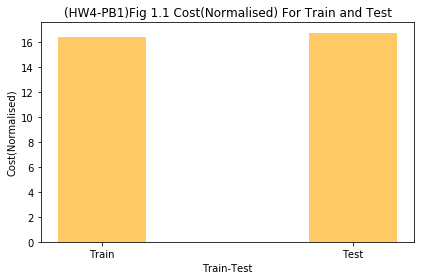

In [132]:
# data to plot
metric_count = 2
cost_metrics = (sp_auto_run_TC2/3500, sp_auto_run_TEC2/1000) 
# create plot
fig, ax = plt.subplots()
index = np.arange(metric_count)
bar_width = 0.35
opacity = 0.6
rects1 = plt.bar(index, cost_metrics, bar_width,
                 alpha=opacity,
                 color='orange')
 

plt.xlabel('Train-Test')
plt.ylabel('Cost(Normalised)')
plt.title('(HW4-PB1)Fig 1.1 Cost(Normalised) For Train and Test')
plt.xticks(index, ('Train', 'Test'))
plt.tight_layout()
plt.show()

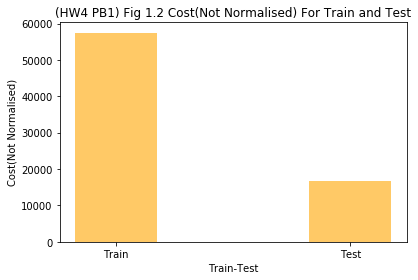

In [133]:
# data to plot
metric_count = 2
cost_metrics = (sp_auto_run_TC2, sp_auto_run_TEC2) 
# create plot
fig, ax = plt.subplots()
index = np.arange(metric_count)
bar_width = 0.35
opacity = 0.6
rects1 = plt.bar(index, cost_metrics, bar_width,
                 alpha=opacity,
                 color='orange')
 

plt.xlabel('Train-Test')
plt.ylabel('Cost(Not Normalised)')
plt.title('(HW4 PB1) Fig 1.2 Cost(Not Normalised) For Train and Test')
plt.xticks(index, ('Train', 'Test'))
plt.tight_layout()
plt.show()

In [108]:
digits_train_cost=[]
digits_train_cost_unnorm=[]
for i in range(0,10):
    tmpind=Y_train_new[Y_train_new.iloc[:,0]==i].index.tolist()
    tmp_arr_x_train_auto = [np.reshape(X_train_new.loc[j,:].tolist(), (len(X_train_new.columns), 1)) for j in tmpind]
    tmp_data_train_auto = list(zip(tmp_arr_x_train_auto, tmp_arr_x_train_auto))
    tmp_train_cost = nn.getError(tmp_data_train_auto)/ len(tmp_data_train_auto)
    digits_train_cost.append(tmp_train_cost)
    digits_train_cost_unnorm.append(nn.getError(tmp_data_train_auto))
    
digits_test_cost=[]
digits_test_cost_unnorm=[]

for i in range(0,10):
    tmpind=Y_test[Y_test.iloc[:,0]==i].index.tolist()
    tmp_arr_x_test_auto = [np.reshape(X_test.loc[j,:].tolist(), (len(X_test.columns), 1)) for j in tmpind]
    tmp_data_test_auto = list(zip(tmp_arr_x_test_auto, tmp_arr_x_test_auto))
    tmp_test_cost = nn.getError(tmp_data_test_auto)/ len(tmp_data_test_auto)
    digits_test_cost.append(tmp_test_cost)
    digits_test_cost_unnorm.append(nn.getError(tmp_data_test_auto))

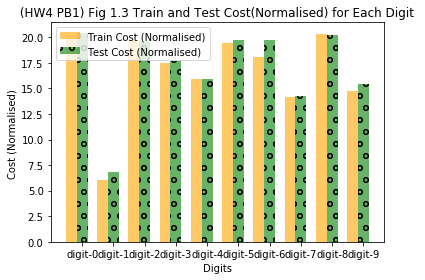

In [136]:
# data to plot
metric_count = 10

# create plot
fig, ax = plt.subplots()
index = np.arange(metric_count)
bar_width = 0.35
opacity = 0.6
rects1 = plt.bar(index, digits_train_cost, bar_width,
                 alpha=opacity,
                 color='orange',
                 label='Train Cost (Normalised)')
 
rects2 = plt.bar(index + bar_width, digits_test_cost, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Test Cost (Normalised)',hatch='o')
plt.xlabel('Digits')
plt.ylabel('Cost (Normalised) ')
plt.title(' (HW4 PB1) Fig 1.3 Train and Test Cost(Normalised) for Each Digit ')
plt.xticks(index + bar_width, ('digit-0', 'digit-1', 'digit-2', 'digit-3','digit-4','digit-5', 'digit-6', 'digit-7', 'digit-8','digit-9'))
plt.legend()
plt.tight_layout()
plt.show()

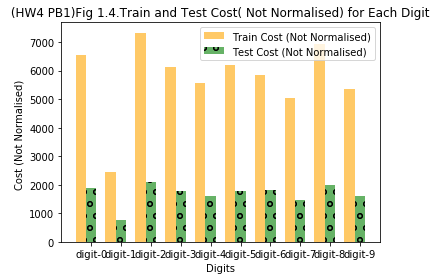

In [137]:
# data to plot
metric_count = 10

# create plot
fig, ax = plt.subplots()
index = np.arange(metric_count)
bar_width = 0.35
opacity = 0.6
rects1 = plt.bar(index, digits_train_cost_unnorm, bar_width,
                 alpha=opacity,
                 color='orange',
                 label='Train Cost (Not Normalised)')
 
rects2 = plt.bar(index + bar_width, digits_test_cost_unnorm, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Test Cost (Not Normalised)',hatch='o')
plt.xlabel('Digits')
plt.ylabel('Cost (Not Normalised) ')
plt.title(' (HW4 PB1)Fig 1.4.Train and Test Cost( Not Normalised) for Each Digit ')
plt.xticks(index + bar_width, ('digit-0', 'digit-1', 'digit-2', 'digit-3','digit-4','digit-5', 'digit-6', 'digit-7', 'digit-8','digit-9'))
plt.legend()
plt.tight_layout()
plt.show()

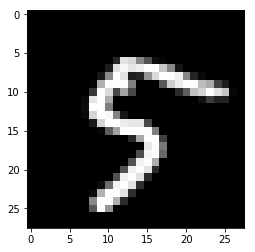

In [111]:
pixels = arr_x_test[0].reshape((28, 28),order='F')
plt.imshow(pixels, cmap='gray')

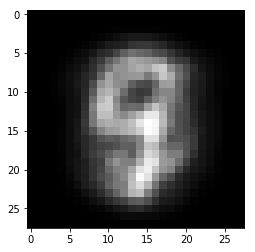

In [112]:
pixels2 = nn.test_auto(arr_x_test[0]).reshape((28, 28),order='F')
plt.imshow(pixels2, cmap='gray')

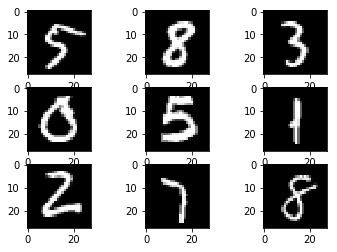

In [113]:
for i in range(9):
    pixels = arr_x_test[i+9*i].reshape((28, 28),order='F')
    plt.subplot(3,3,i+1)
    plt.imshow(pixels, cmap='gray')

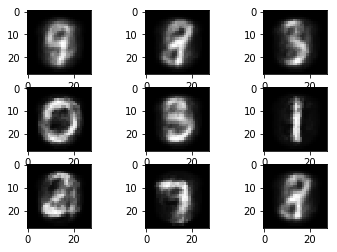

In [114]:
for i in range(9):
    #pixels = arr_x_train[i].reshape((28, 28),order='F')
    pixels2 = nn.test_auto(arr_x_test[i+9*i]).reshape((28, 28),order='F')
    plt.subplot(3,3,i+1)
    plt.imshow(pixels2, cmap='gray')

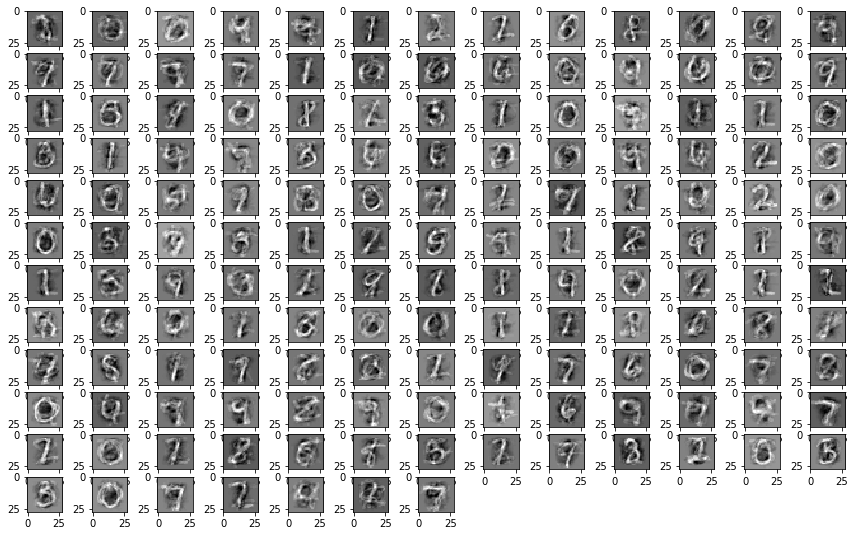

In [115]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))

for i in range(150):
    #pixels = arr_x_train[i].reshape((28, 28),order='F')
    pixe = nn.W[1][i].reshape((28, 28),order='F')
    plt.subplot(13,13,i+1)
    plt.imshow(pixe, cmap='gray')

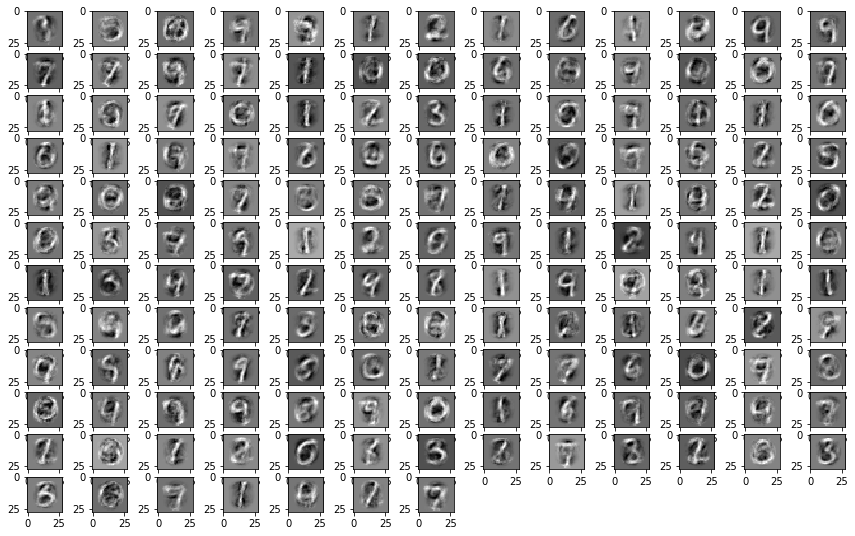

In [116]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
for i in range(150):
    #pixels = arr_x_train[i].reshape((28, 28),order='F')
    pixels2 = nn.W[2][:,i].reshape((28, 28),order='F')
    plt.subplot(13,13,i+1)
    plt.imshow(pixels2, cmap='gray')

## end for run with tuned parameters

## (HW3-PB2) RAN BEFORE CODE CHANGES I.E. SPARSE AND WEIGHT DECAY 

In [54]:
# After balanced split

#initialize layer sizes as list
layers = [784,150,784]
act_funcs=['NR','sigmoid','sigmoid']
momentum = 0.7
lr = 0.1
itrs = 1
batch_size = 32

nn = Model(layers,act_funcs, lr, momentum, itrs, batch_size,True)

#training neural network
Run1=nn.train(data_train_auto, data_val_auto, data_test_auto,True)



For epoch 0, validating error 50154.7864886297 , training error 351020.2100972497 , testing error 100284.5346735472.


In [55]:
nn.load(30,0.1,0.7,'auto-intial-150.pkl',['NR','relu','sigmoid'])
Run_main=nn.train(data_train_auto, data_val_auto, data_test_auto,True)

For epoch 0, validating error 47316.157105828956 , training error 331003.4632347969 , testing error 94568.2448476143.
For epoch 10, validating error 3568.0176867656246 , training error 24600.461316003384 , testing error 7288.014744142487.
For epoch 20, validating error 3474.813503443725 , training error 23912.830458150514 , testing error 7119.55496182584.
For epoch 30, validating error 3511.6235102074284 , training error 24312.28069105375 , testing error 7200.387408153512.


In [56]:
nn.load(50,0.05,0.7,'auto-intial-150.pkl',['NR','relu','sigmoid'])
Run_main=nn.train(data_train_auto, data_val_auto, data_test_auto,True)

For epoch 0, validating error 47316.157105828956 , training error 331003.46323479776 , testing error 94568.2448476143.
For epoch 10, validating error 4828.04768806673 , training error 34003.147488514354 , testing error 9922.30156789678.
For epoch 20, validating error 4811.908943053235 , training error 33767.51559672645 , testing error 9821.65008540394.
For epoch 30, validating error 4745.468806047451 , training error 33342.38329269066 , testing error 9739.884914858096.
For epoch 40, validating error 4747.074680112115 , training error 33356.01422741854 , testing error 9743.702584235643.
For epoch 50, validating error 4769.570033409725 , training error 33505.651727496836 , testing error 9761.166762351162.


In [57]:
nn.load(50,0.05,0.9,'auto-intial-150.pkl',['NR','relu','sigmoid'])
Run_main=nn.train(data_train_auto, data_val_auto, data_test_auto,True)

For epoch 0, validating error 47316.157105828956 , training error 331003.4632347972 , testing error 94568.2448476143.
For epoch 10, validating error 5193.192175125563 , training error 36584.93073294209 , testing error 10670.208143247184.
For epoch 20, validating error 5117.56000372326 , training error 36094.55358631323 , testing error 10531.052457829355.
For epoch 30, validating error 5196.968505394251 , training error 36594.5582478644 , testing error 10668.123430521604.
For epoch 40, validating error 5254.28494760393 , training error 36931.026504068774 , testing error 10796.907268098723.
For epoch 50, validating error 5019.329213317542 , training error 35331.95749024757 , testing error 10300.50898074677.


In [58]:
nn.load(60,0.05,0.9,'auto-0.05-0.9relu-sigmoid30.pkl',['NR','relu','sigmoid'])
Run_main=nn.train(data_train_auto, data_val_auto, data_test_auto,True)

For epoch 0, validating error 5196.968505394251 , training error 36594.55824786435 , testing error 10668.123430521604.
For epoch 10, validating error 5123.848204894478 , training error 35917.083747723285 , testing error 10506.506778048499.
For epoch 20, validating error 5044.023749620204 , training error 35540.53810344482 , testing error 10342.184858838422.
For epoch 30, validating error 5172.482484030309 , training error 36654.73621246952 , testing error 10670.970769687205.
For epoch 40, validating error 5116.401732923601 , training error 36088.65856231093 , testing error 10559.502833038126.
For epoch 50, validating error 4996.180328444997 , training error 35329.521077057565 , testing error 10320.106783521394.
For epoch 60, validating error 5054.790772640387 , training error 35649.10876837859 , testing error 10401.885628013293.


In [59]:
nn.load(90,0.05,0.3,'auto-intial-150.pkl',['NR','relu','sigmoid'])
Run_main=nn.train(data_train_auto, data_val_auto, data_test_auto,True)

For epoch 0, validating error 47316.157105828956 , training error 331003.46323479776 , testing error 94568.2448476143.
For epoch 10, validating error 4720.590695286898 , training error 33238.30130878486 , testing error 9695.286887486587.
For epoch 20, validating error 4557.0686461561845 , training error 32105.78699923228 , testing error 9367.724673701976.
For epoch 30, validating error 4580.413720660587 , training error 32228.56503603509 , testing error 9414.23277772417.
For epoch 40, validating error 4523.991348090157 , training error 31856.21302292983 , testing error 9282.103566865062.
For epoch 50, validating error 4559.910455135306 , training error 32011.368754376133 , testing error 9352.273184952175.
For epoch 60, validating error 4520.430135435121 , training error 31841.656556953243 , testing error 9289.751995042085.
For epoch 70, validating error 4580.375455080293 , training error 32100.11293389321 , testing error 9375.129162041378.
For epoch 80, validating error 4562.1703962184

In [52]:
nn.load(30,0.1,0.7,'auto-intial-150.pkl',['NR','relu','sigmoid'])
Run_main=nn.train(data_train_auto, data_val_auto, data_test_auto,True)

For epoch 0, validating error 47316.157105828956 , training error 331003.4632347964 , testing error 94568.2448476143.
For epoch 10, validating error 1216.3514140604912 , training error 7562.304376282191 , testing error 2537.7085565340653.
For epoch 20, validating error 959.359004612907 , training error 5582.386542048741 , testing error 1990.295778581694.
For epoch 30, validating error 874.2574278887996 , training error 4859.6159548158985 , testing error 1807.6002281032752.


In [47]:
nn.load(30,0.1,0.7,'auto-intial-150.pkl',['NR','relu','sigmoid'])
Run_main=nn.train(data_train_auto, data_val_auto, data_test_auto,True)

For epoch 0, validating error 47316.157105828956 , training error 331003.4632347976 , testing error 94568.2448476143.
For epoch 10, validating error 1229.5583781574994 , training error 7573.9132528139135 , testing error 2575.212743350331.
For epoch 20, validating error 1003.6540715900526 , training error 5751.811704514097 , testing error 2105.431300351034.
For epoch 30, validating error 931.2926730100494 , training error 5029.484199673259 , testing error 1932.7600665238263.


In [34]:
nn.load(30,0.1,0.7,'auto-intial-150.pkl',['NR','relu','sigmoid'])
Run_main=nn.train(data_train_auto, data_val_auto, data_test_auto,True)

For epoch 0, validating error 47359.874019817085 , training error 331614.6401186703 , testing error 94679.7402985663.
For epoch 10, validating error 1179.194539648837 , training error 7146.843767103401 , testing error 2482.4345624503967.
For epoch 20, validating error 931.1780443434411 , training error 5213.848463331555 , testing error 1992.8426393849002.
For epoch 30, validating error 906.5991734008701 , training error 4819.321125856506 , testing error 1933.8288864302888.


## Different Running Auto Encoder with specifications as given in code

In [31]:
nn.load(500,0.1,0.7,'auto-intial-150.pkl',['NR','relu','sigmoid'])
Run_main=nn.train(data_train_auto, data_val_auto, data_test_auto,True)

For epoch 0, validating error 47316.157105828956 , training error 331003.46323479665 , testing error 94568.2448476143.
For epoch 10, validating error 1199.4114102618214 , training error 7504.6153874709125 , testing error 2533.3186812769895.
For epoch 20, validating error 1001.3867104705193 , training error 5680.286302907854 , testing error 2086.3207599614407.
For epoch 30, validating error 967.0491354596202 , training error 5254.193622331725 , testing error 2008.5823036287088.
For epoch 40, validating error 893.84172993112 , training error 4676.247191732909 , testing error 1853.1346217665407.
For epoch 50, validating error 877.3337866384113 , training error 4444.367661015447 , testing error 1822.220261174165.
For epoch 60, validating error 875.6522265138773 , training error 4353.259759017557 , testing error 1817.72965286358.
For epoch 70, validating error 858.966552609616 , training error 4200.336582166419 , testing error 1793.6007347449154.
For epoch 80, validating error 841.773567027

In [32]:
Run1_tec=[x / 1000 for x in Run_main['tec']]
Run1_tc=[x / 3500 for x in Run_main['tc']]
Run1_vc=[x / 500 for x in Run_main['vc']]

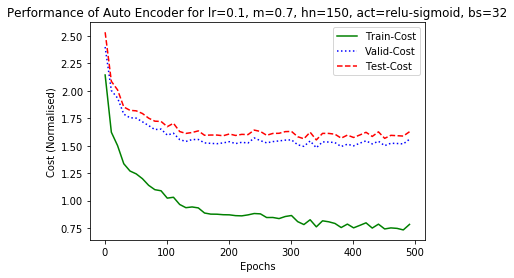

In [33]:
epoch = range(1,501,10)
plt.plot(epoch, Run1_tc[1:], color='g',linestyle='-',label='Train-Cost')
plt.plot(epoch, Run1_vc[1:], color='blue' ,linestyle='dotted',label='Valid-Cost')
plt.plot(epoch, Run1_tec[1:], color='red',linestyle='dashed',label='Test-Cost')
plt.xlabel('Epochs')
plt.ylabel('Cost (Normalised)')
plt.legend()
plt.title('Performance of Auto Encoder for lr=0.1, m=0.7, hn=150, act=relu-sigmoid, bs=32')
plt.show()

In [34]:
sp_auto_run_TEC=Run_main['tec'][-1]
sp_auto_run_TC=Run_main['tc'][-1]

In [ ]:
# data to plot
metric_count = 2
cost_metrics = (sp_auto_run_TC/3500, sp_auto_run_TEC/1000) 
# create plot
fig, ax = plt.subplots()
index = np.arange(metric_count)
bar_width = 0.35
opacity = 0.6
rects1 = plt.bar(index, cost_metrics, bar_width,
                 alpha=opacity,
                 color='orange')
 

plt.xlabel('Train-Test')
plt.ylabel('Cost(Normalised)')
plt.title('(HW3-PB2)Fig 2.1 Cost(Normalised) For Train and Test')
plt.xticks(index, ('Train', 'Test'))
plt.tight_layout()
plt.show()

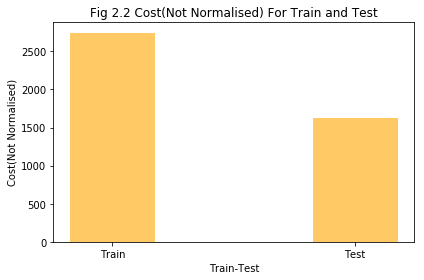

In [36]:
# data to plot
metric_count = 2
cost_metrics = (sp_auto_run_TC, sp_auto_run_TEC) 
# create plot
fig, ax = plt.subplots()
index = np.arange(metric_count)
bar_width = 0.35
opacity = 0.6
rects1 = plt.bar(index, cost_metrics, bar_width,
                 alpha=opacity,
                 color='orange')
 

plt.xlabel('Train-Test')
plt.ylabel('Cost(Not Normalised)')
plt.title('Fig 2.2 Cost(Not Normalised) For Train and Test')
plt.xticks(index, ('Train', 'Test'))
plt.tight_layout()
plt.show()

In [37]:
digits_train_cost=[]
digits_train_cost_unnorm=[]
for i in range(0,10):
    tmpind=Y_train_new[Y_train_new.iloc[:,0]==i].index.tolist()
    tmp_arr_x_train_auto = [np.reshape(X_train_new.loc[j,:].tolist(), (len(X_train_new.columns), 1)) for j in tmpind]
    tmp_data_train_auto = list(zip(tmp_arr_x_train_auto, tmp_arr_x_train_auto))
    tmp_train_cost = nn.getError(tmp_data_train_auto)/ len(tmp_data_train_auto)
    digits_train_cost.append(tmp_train_cost)
    digits_train_cost_unnorm.append(nn.getError(tmp_data_train_auto))
    
digits_test_cost=[]
digits_test_cost_unnorm=[]

for i in range(0,10):
    tmpind=Y_test[Y_test.iloc[:,0]==i].index.tolist()
    tmp_arr_x_test_auto = [np.reshape(X_test.loc[j,:].tolist(), (len(X_test.columns), 1)) for j in tmpind]
    tmp_data_test_auto = list(zip(tmp_arr_x_test_auto, tmp_arr_x_test_auto))
    tmp_test_cost = nn.getError(tmp_data_test_auto)/ len(tmp_data_test_auto)
    digits_test_cost.append(tmp_test_cost)
    digits_test_cost_unnorm.append(nn.getError(tmp_data_test_auto))

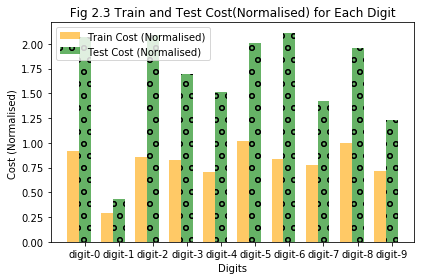

In [38]:
# data to plot
metric_count = 10

# create plot
fig, ax = plt.subplots()
index = np.arange(metric_count)
bar_width = 0.35
opacity = 0.6
rects1 = plt.bar(index, digits_train_cost, bar_width,
                 alpha=opacity,
                 color='orange',
                 label='Train Cost (Normalised)')
 
rects2 = plt.bar(index + bar_width, digits_test_cost, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Test Cost (Normalised)',hatch='o')
plt.xlabel('Digits')
plt.ylabel('Cost (Normalised) ')
plt.title(' Fig 2.3 Train and Test Cost(Normalised) for Each Digit ')
plt.xticks(index + bar_width, ('digit-0', 'digit-1', 'digit-2', 'digit-3','digit-4','digit-5', 'digit-6', 'digit-7', 'digit-8','digit-9'))
plt.legend()
plt.tight_layout()
plt.show()

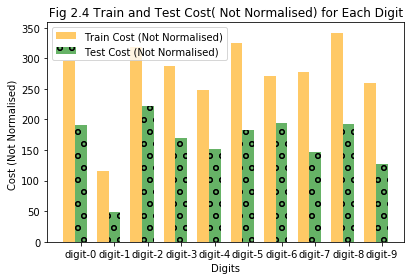

In [39]:
# data to plot
metric_count = 10

# create plot
fig, ax = plt.subplots()
index = np.arange(metric_count)
bar_width = 0.35
opacity = 0.6
rects1 = plt.bar(index, digits_train_cost_unnorm, bar_width,
                 alpha=opacity,
                 color='orange',
                 label='Train Cost (Not Normalised)')
 
rects2 = plt.bar(index + bar_width, digits_test_cost_unnorm, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Test Cost (Not Normalised)',hatch='o')
plt.xlabel('Digits')
plt.ylabel('Cost (Not Normalised) ')
plt.title(' Fig 2.4 Train and Test Cost( Not Normalised) for Each Digit ')
plt.xticks(index + bar_width, ('digit-0', 'digit-1', 'digit-2', 'digit-3','digit-4','digit-5', 'digit-6', 'digit-7', 'digit-8','digit-9'))
plt.legend()
plt.tight_layout()
plt.show()

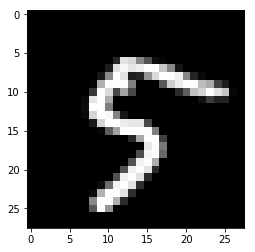

In [40]:
pixels = arr_x_test[0].reshape((28, 28),order='F')
plt.imshow(pixels, cmap='gray')

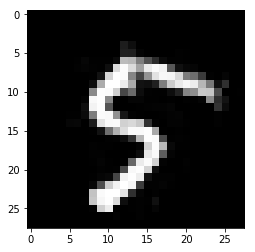

In [41]:
pixels2 = nn.test_auto(arr_x_test[0]).reshape((28, 28),order='F')
plt.imshow(pixels2, cmap='gray')

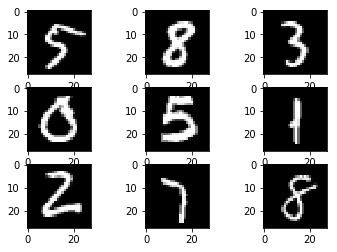

In [42]:
for i in range(9):
    pixels = arr_x_test[i+9*i].reshape((28, 28),order='F')
    plt.subplot(3,3,i+1)
    plt.imshow(pixels, cmap='gray')

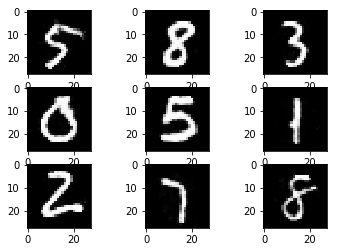

In [43]:
for i in range(9):
    #pixels = arr_x_train[i].reshape((28, 28),order='F')
    pixels2 = nn.test_auto(arr_x_test[i+9*i]).reshape((28, 28),order='F')
    plt.subplot(3,3,i+1)
    plt.imshow(pixels2, cmap='gray')

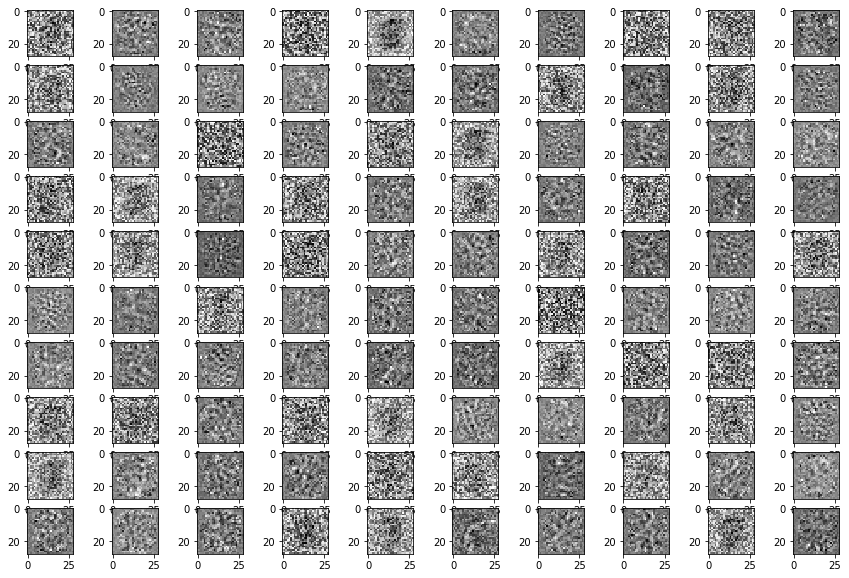

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))

for i in range(100):
    pixels2 = nn.W[1][i].reshape((28, 28),order='F')
    plt.subplot(10,10,i+1)
    plt.imshow(pixels2, cmap='gray')

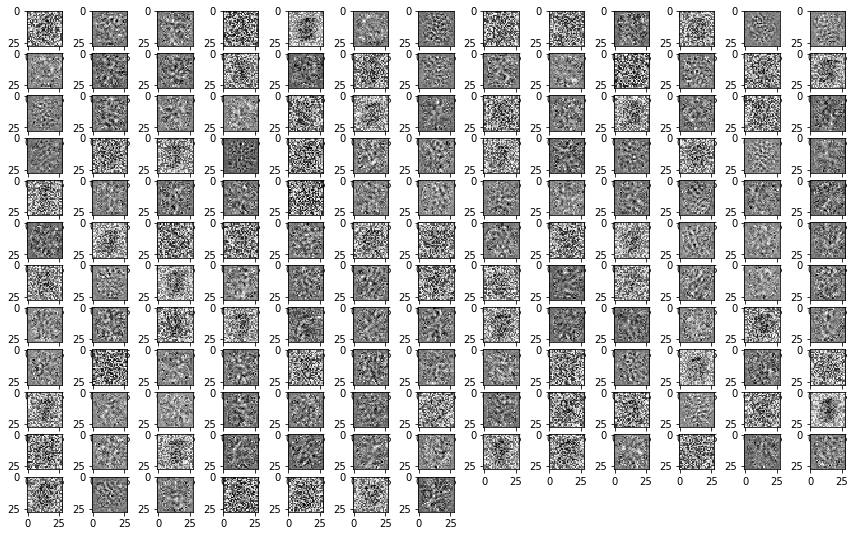

In [45]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))

for i in range(150):
    #pixels = arr_x_train[i].reshape((28, 28),order='F')
    pixels2 = nn.W[1][i].reshape((28, 28),order='F')
    plt.subplot(13,13,i+1)
    plt.imshow(pixels2, cmap='gray')

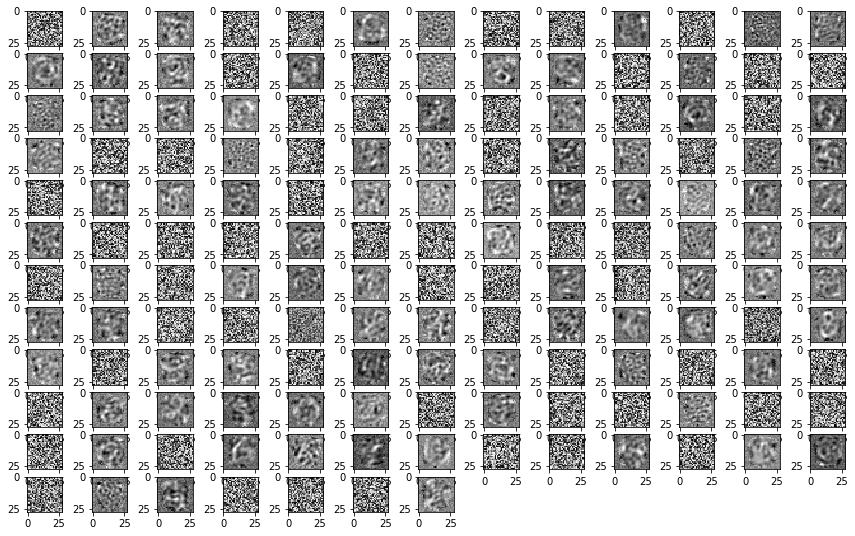

In [46]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
for i in range(150):
    #pixels = arr_x_train[i].reshape((28, 28),order='F')
    pixels2 = nn.W[2][:,i].reshape((28, 28),order='F')
    plt.subplot(13,13,i+1)
    plt.imshow(pixels2, cmap='gray')